<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/use_tm_vec_to_predict_tm_scores_for_pairs_of_sequences_noha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library.
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to predict TM-Scores for pairs of protein sequences.


<h3>Predicting TM-Scores using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, deepblast, and the huggingface transformers library**

In [1]:
!pip install tm-vec

In [2]:
!pip install deepblast

In [3]:
!pip install -q SentencePiece transformers

<b>2. Load the relevant libraries<b>

In [4]:
%pip install faiss-gpu
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm


import matplotlib.pyplot as plt
import seaborn as sns


<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [5]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

In [7]:
gc.collect()

226

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
print(device)

cuda:0


In [10]:
model = model.to(device)
model = model.eval()

<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt

--2022-12-21 16:37:24--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt [following]
--2022-12-21 16:37:24--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 207922348 (198M) [application/octet-stream]
Saving to: ‘tm_vec_cath_model.ckpt’

tm_vec_cath_model.c 100%[===================>] 198.29M  25.0MB/s    in 7.7s    

2022-12-21 16:37:32 (25.8 MB/s) - ‘tm_vec_cath_model.ckpt’ saved [207922348/207922348]



In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json

--2022-12-21 16:37:32--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json [following]
--2022-12-21 16:37:33--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 181 [application/json]
Saving to: ‘tm_vec_cath_model_params.json’

tm_vec_cath_model_p 100%[===================>]     181  --.-KB/s    in 0s      

2022-12-21 16:37:33 (57.5 MB/s) - ‘tm_vec_cath_model_params.json’ saved [181/181]



<b> 5. Load the trained TM-Vec model<b>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#TM-Vec model paths
tm_vec_model_cpnt = "/content/drive/MyDrive/tm_vec_cath_model.ckpt"
tm_vec_model_config = "/content/drive/MyDrive/tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/tm_vec_cath_model.ckpt`


<b> 6. Load or paste some pairs of protein sequences that you would like to predict TM-Scores for<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv

--2022-12-21 16:41:25--  https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv [following]
--2022-12-21 16:41:25--  https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 65007 (63K) [application/octet-stream]
Saving to: ‘malidup_sequences_and_tm_scores.csv’

malidup_sequences_a 100%[===================>]  63.48K  --.-KB/s    in 0.08s   

2022-12-21 16:41:25 (806 KB/s) - ‘malidup_sequences_and_tm_scores.csv’ saved [65007/65007]



In [ ]:
sequences = pd.read_csv('malidup_sequences_and_tm_scores.csv')

In [ ]:
#Sample some sequences (for running on CPU which is much slower)
sequence_df = sequences.sample(25).reset_index(drop=True)

<b> 7. Predict TM-Scores using TM-Vec <b>



In [ ]:
#This will be much faster (orders of magnitude) on a GPU than a CPU
tm_score_predictions = []
for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'Sequence 1']
    sequence_2 = sequence_df.loc[i, 'Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    #Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    #Embed sequence 1 and 2 using TM-Vec, applied to the ProtTrans features
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    #Predict the TM-score for sequence 1 and 2, using the TM-Vec embeddings
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
      print(i, " TM-Scores predicted")

0  TM-Scores predicted
10  TM-Scores predicted
20  TM-Scores predicted


<b>8. Visualize TM-score predictions versus the ground truth TM-scores<b>

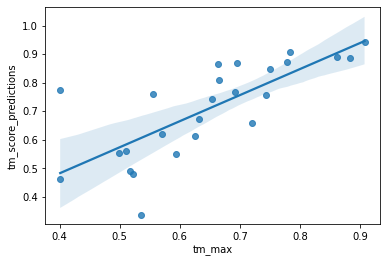

In [ ]:
sequence_df['tm_score_predictions'] = np.array(tm_score_predictions)
sns.regplot(data=sequence_df, x="tm_max", y="tm_score_predictions")

Streaming output truncated to the last 5000 lines.
Progress: 50020/100000 TM-Scores predicted
Progress: 50030/100000 TM-Scores predicted
Progress: 50040/100000 TM-Scores predicted
Progress: 50050/100000 TM-Scores predicted
Progress: 50060/100000 TM-Scores predicted
Progress: 50070/100000 TM-Scores predicted
Progress: 50080/100000 TM-Scores predicted
Progress: 50090/100000 TM-Scores predicted
Progress: 50100/100000 TM-Scores predicted
Progress: 50110/100000 TM-Scores predicted
Progress: 50120/100000 TM-Scores predicted
Progress: 50130/100000 TM-Scores predicted
Progress: 50140/100000 TM-Scores predicted
Progress: 50150/100000 TM-Scores predicted
Progress: 50160/100000 TM-Scores predicted
Progress: 50170/100000 TM-Scores predicted
Progress: 50180/100000 TM-Scores predicted
Progress: 50190/100000 TM-Scores predicted
Progress: 50200/100000 TM-Scores predicted
Progress: 50210/100000 TM-Scores predicted
Progress: 50220/100000 TM-Scores predicted
Progress: 50230/100000 TM-Scores predicted
Pro

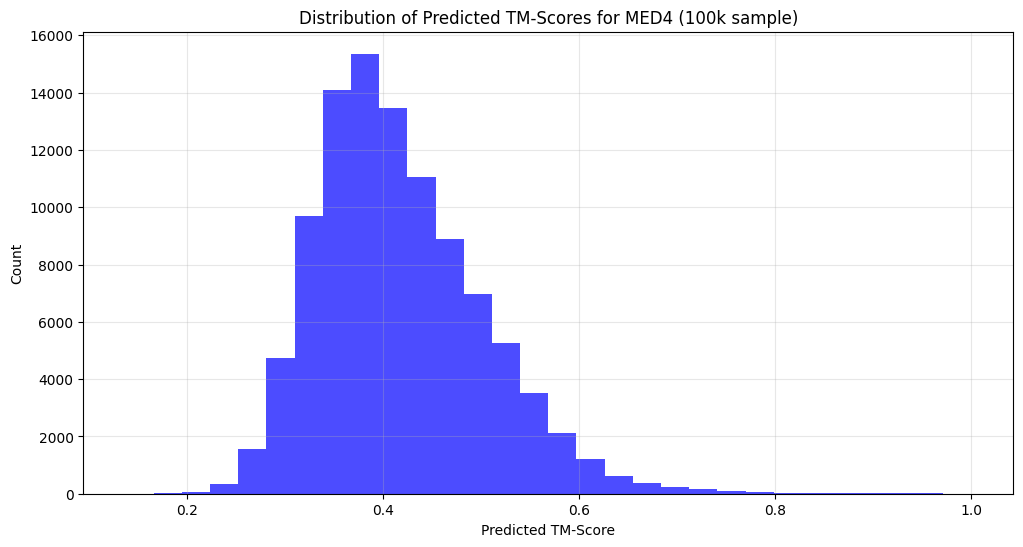


Summary Statistics of Predictions:
count    100000.000000
mean          0.417092
std           0.084690
min           0.136980
25%           0.356586
50%           0.404123
75%           0.467386
max           1.000000
dtype: float64


In [14]:


# Load your CSV file from Google Drive
file_path = '/content/drive/MyDrive/MED4_full.csv'
pairs_df = pd.read_csv(file_path, header=None, names=['Sequence 1', 'Sequence 2'])

# Convert comma-separated sequences into separate columns if needed
if pairs_df.shape[1] == 1:
    pairs_df[['Sequence 1', 'Sequence 2']] = pairs_df[0].str.split(',', expand=True)
    pairs_df = pairs_df.drop(0, axis=1)

# Sample 500,000 sequences randomly
sampled_pairs_df = pairs_df.sample(n=100000, random_state=42)

print(f"Original number of sequence pairs: {len(pairs_df)}")
print(f"Number of sampled sequence pairs: {len(sampled_pairs_df)}")
print("\nFirst few sampled pairs:")
print(sampled_pairs_df.head())

# Now predict TM-Scores
tm_score_predictions = []
for i in range(sampled_pairs_df.shape[0]):
    sequence_1 = sampled_pairs_df.iloc[i]['Sequence 1']
    sequence_2 = sampled_pairs_df.iloc[i]['Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    # Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    # Embed sequence 1 and 2 using TM-Vec
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    # Predict the TM-score
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
        print(f"Progress: {i}/{len(sampled_pairs_df)} TM-Scores predicted")

# Add predictions to dataframe
sampled_pairs_df['TM_Score_Prediction'] = np.array(tm_score_predictions)

# Save results back to Google Drive
output_path = '/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv'
sampled_pairs_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualizations
plt.figure(figsize=(12, 6))
plt.hist(tm_score_predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted TM-Scores for MED4 (100k sample)')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nSummary Statistics of Predictions:")
print(pd.Series(tm_score_predictions).describe())

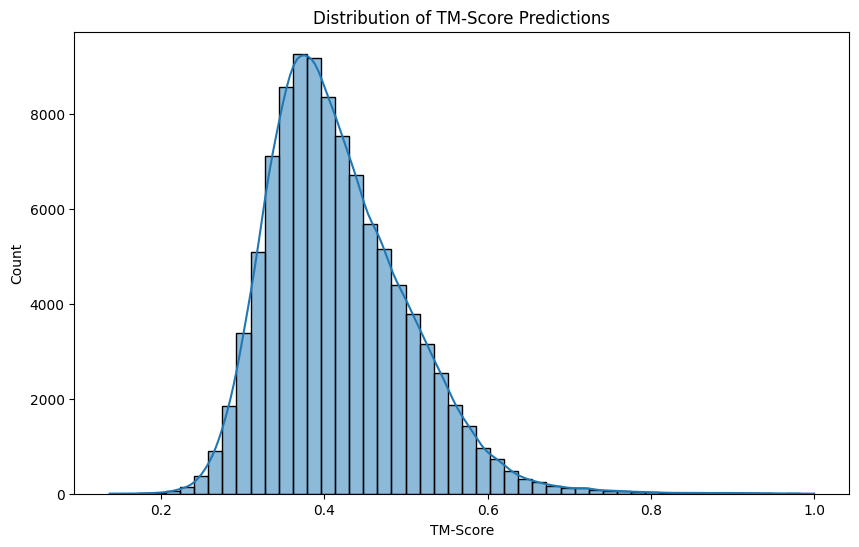

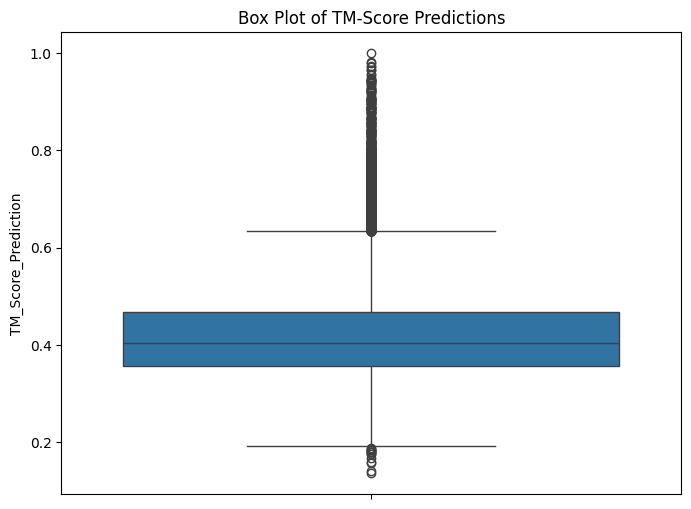

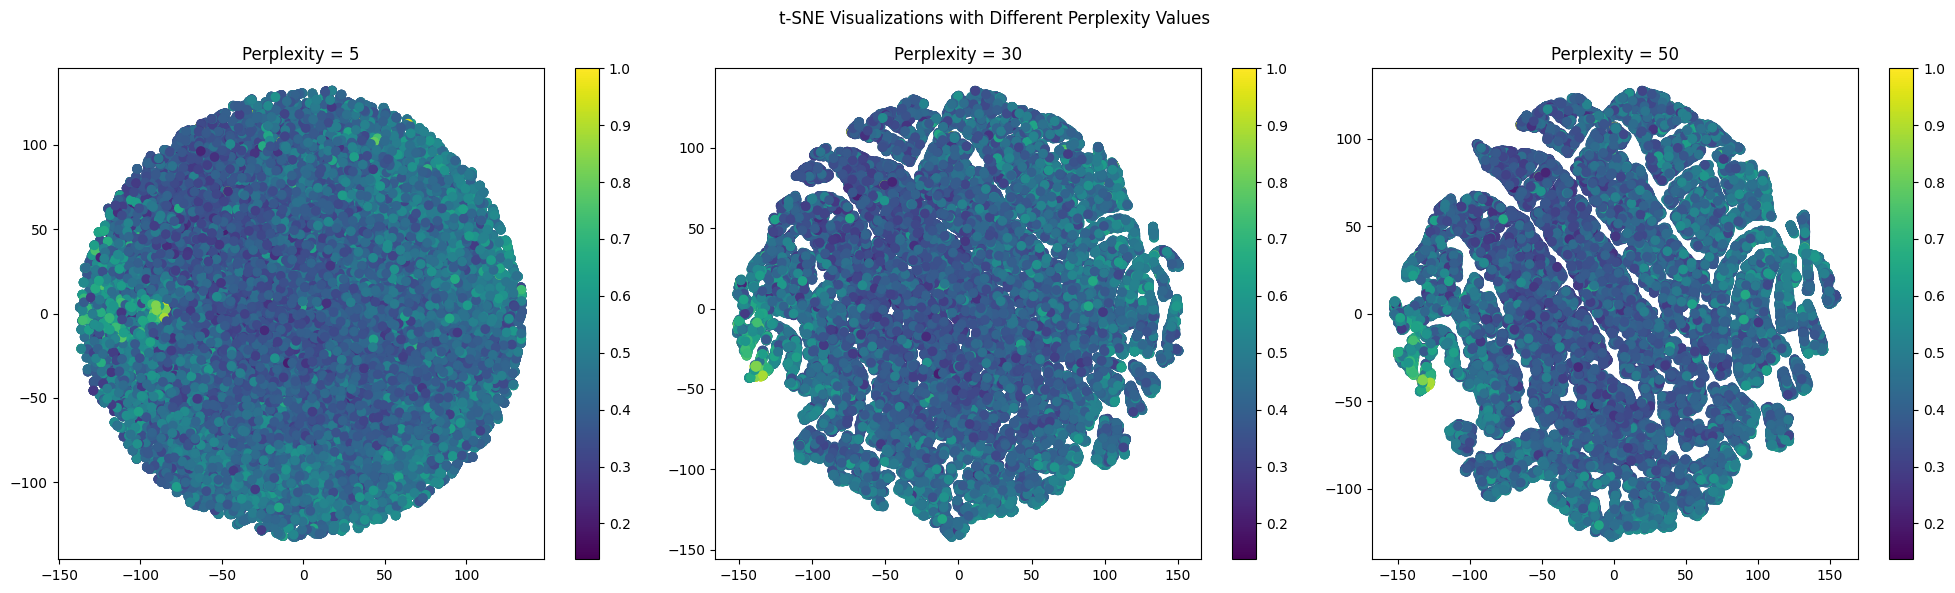

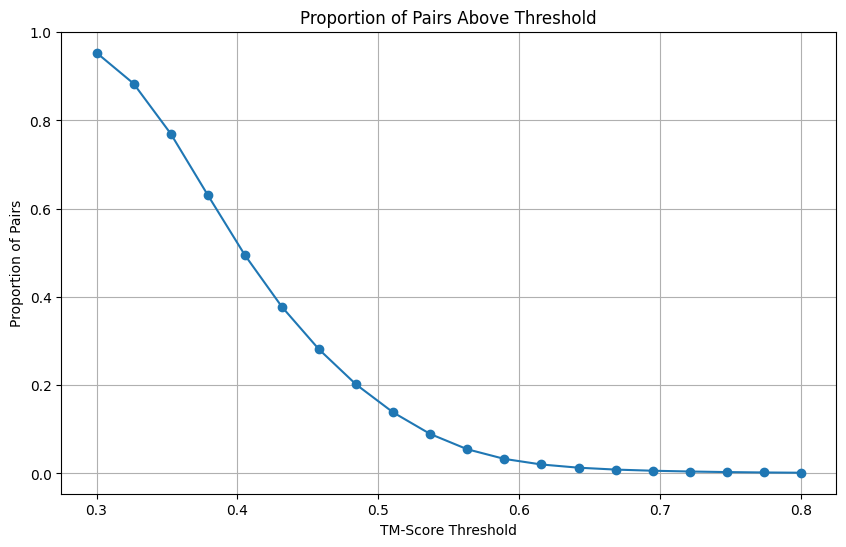

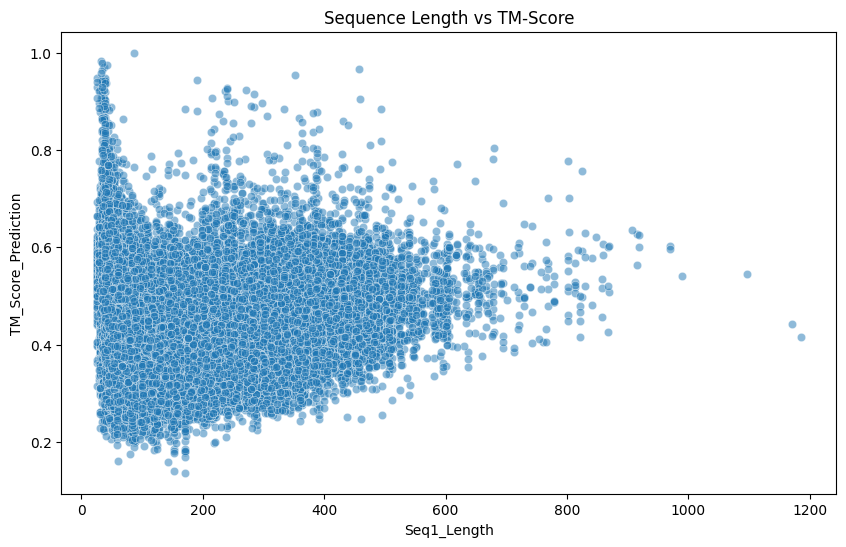

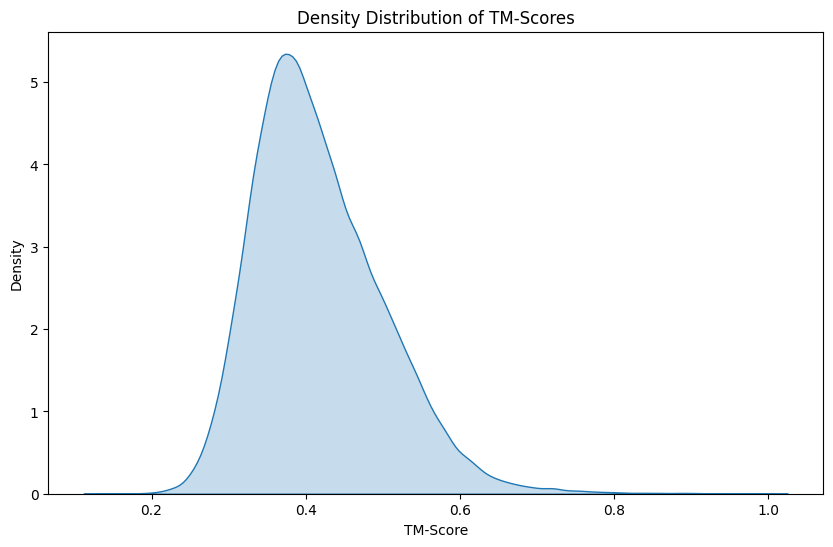


Summary Statistics of TM-Scores:
count    100000.000000
mean          0.417092
std           0.084691
min           0.136980
25%           0.356586
50%           0.404123
75%           0.467386
max           1.000000
Name: TM_Score_Prediction, dtype: float64


<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# 1. Basic Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='TM_Score_Prediction', bins=50, kde=True)
plt.title('Distribution of TM-Score Predictions')
plt.xlabel('TM-Score')
plt.ylabel('Count')
plt.show()

# 2. Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=results_df['TM_Score_Prediction'])
plt.title('Box Plot of TM-Score Predictions')
plt.show()

# 3. t-SNE Visualizations with different perplexity values
def plot_tsne_multiple_perplexity(data, perplexities=[5, 30, 50]):
    fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 6))
    fig.suptitle('t-SNE Visualizations with Different Perplexity Values')

    for idx, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2,
                    perplexity=perp,
                    random_state=42)

        tsne_results = tsne.fit_transform(data)

        scatter = axes[idx].scatter(tsne_results[:, 0], tsne_results[:, 1],
                                  c=results_df['TM_Score_Prediction'],
                                  cmap='viridis')
        axes[idx].set_title(f'Perplexity = {perp}')
        plt.colorbar(scatter, ax=axes[idx])

    plt.tight_layout()
    plt.show()

# Prepare data for t-SNE
# Create feature vectors by combining sequence properties
sequence_features = np.column_stack((
    results_df['TM_Score_Prediction'],
    [len(seq) for seq in results_df['Sequence 1']],
    [len(seq) for seq in results_df['Sequence 2']]
))

# Plot t-SNE with different perplexities
plot_tsne_multiple_perplexity(sequence_features)

# 4. Performance Metrics at Different Thresholds
def analyze_threshold_performance():
    thresholds = np.linspace(0.3, 0.8, 20)
    metrics = []

    for threshold in thresholds:
        predictions = results_df['TM_Score_Prediction'] >= threshold
        metrics.append({
            'threshold': threshold,
            'ratio': np.mean(predictions)
        })

    metrics_df = pd.DataFrame(metrics)

    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['threshold'], metrics_df['ratio'], marker='o')
    plt.title('Proportion of Pairs Above Threshold')
    plt.xlabel('TM-Score Threshold')
    plt.ylabel('Proportion of Pairs')
    plt.grid(True)
    plt.show()

analyze_threshold_performance()

# 5. Correlation Analysis
def analyze_sequence_length_correlation():
    results_df['Seq1_Length'] = results_df['Sequence 1'].str.len()
    results_df['Seq2_Length'] = results_df['Sequence 2'].str.len()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='Seq1_Length', y='TM_Score_Prediction', alpha=0.5)
    plt.title('Sequence Length vs TM-Score')
    plt.show()

analyze_sequence_length_correlation()

# 6. Density Plot of TM-Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(data=results_df['TM_Score_Prediction'], fill=True)
plt.title('Density Distribution of TM-Scores')
plt.xlabel('TM-Score')
plt.ylabel('Density')
plt.show()

# 7. Summary Statistics
print("\nSummary Statistics of TM-Scores:")
print(results_df['TM_Score_Prediction'].describe())

# Save all visualizations
plt.savefig('tm_score_visualizations.pdf')

Basic Statistical Analysis:
--------------------------------------------------
Mean TM-Score: 0.4171
Median TM-Score: 0.4041
Standard Deviation: 0.0847
Variance: 0.0072
Minimum: 0.1370
Maximum: 1.0000

Quartile Analysis:
First Quartile (Q1): 0.3566
Third Quartile (Q3): 0.4674
Interquartile Range (IQR): 0.1108

Distribution Analysis:
--------------------------------------------------
Skewness: 0.8862
Kurtosis: 1.6700

Normality Test (D'Agostino-Pearson):
Statistic: 13580.9263
p-value: 0.0000e+00
Conclusion: Data is not normally distributed


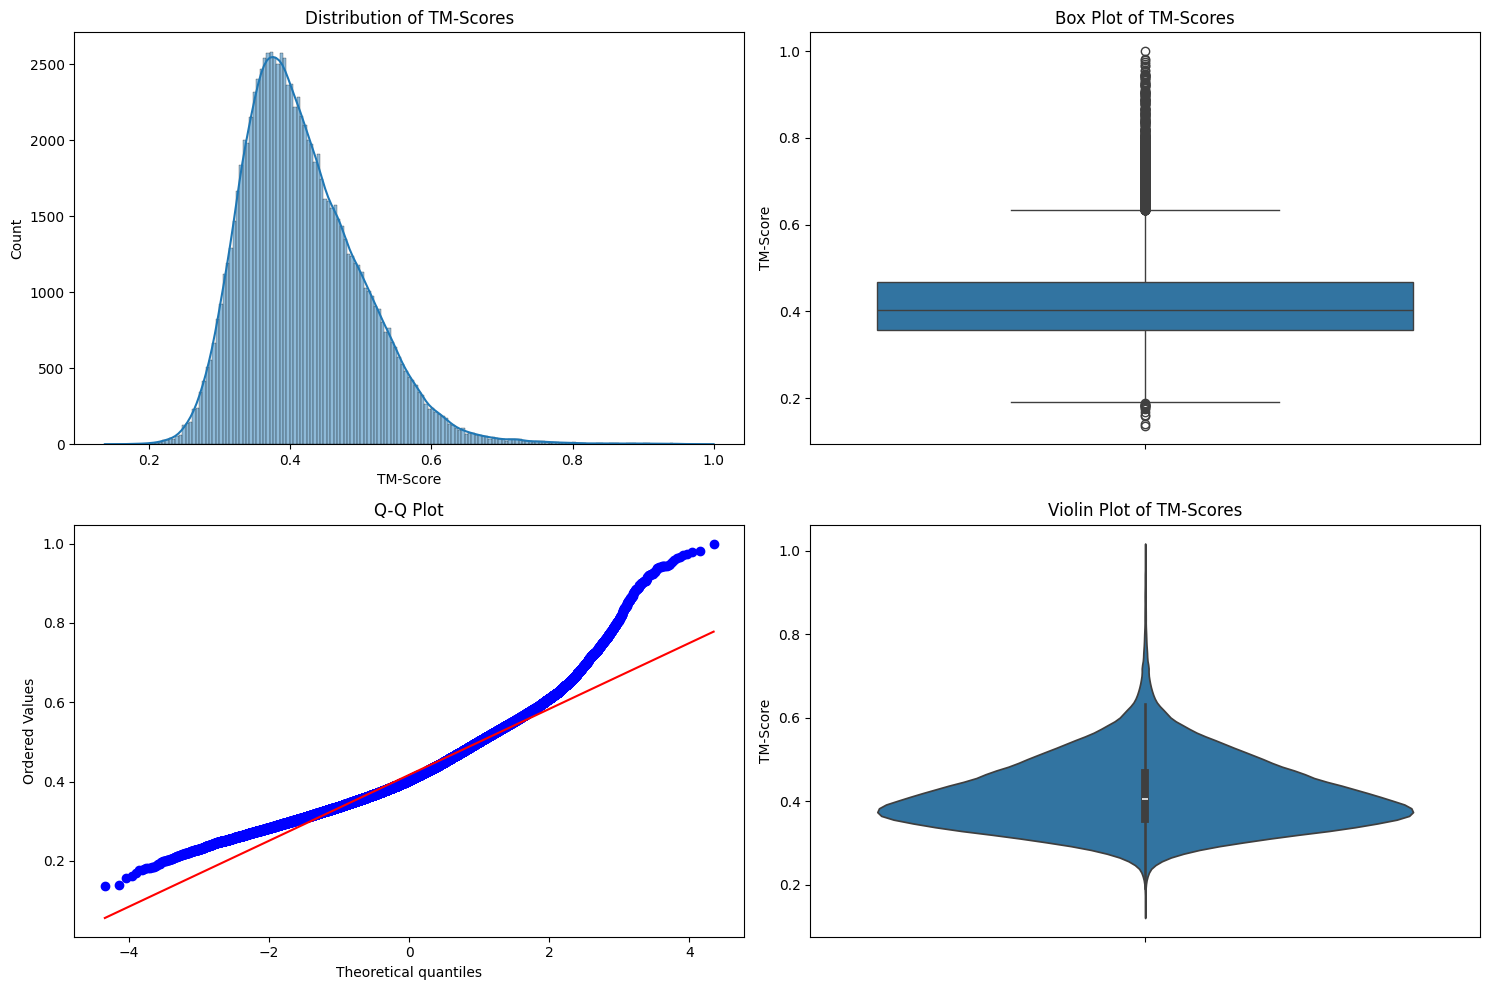


Sequence Length Analysis:
--------------------------------------------------

Correlation between sequence lengths and TM-Score:
Correlation (Seq1 Length vs TM-Score): 0.0873
Correlation (Seq2 Length vs TM-Score): 0.1020

Threshold Analysis:
--------------------------------------------------
Pairs with TM-Score >= 0.3: 95.34%
Pairs with TM-Score >= 0.4: 52.07%
Pairs with TM-Score >= 0.5: 16.18%
Pairs with TM-Score >= 0.6: 2.72%
Pairs with TM-Score >= 0.7: 0.56%
Pairs with TM-Score >= 0.8: 0.15%


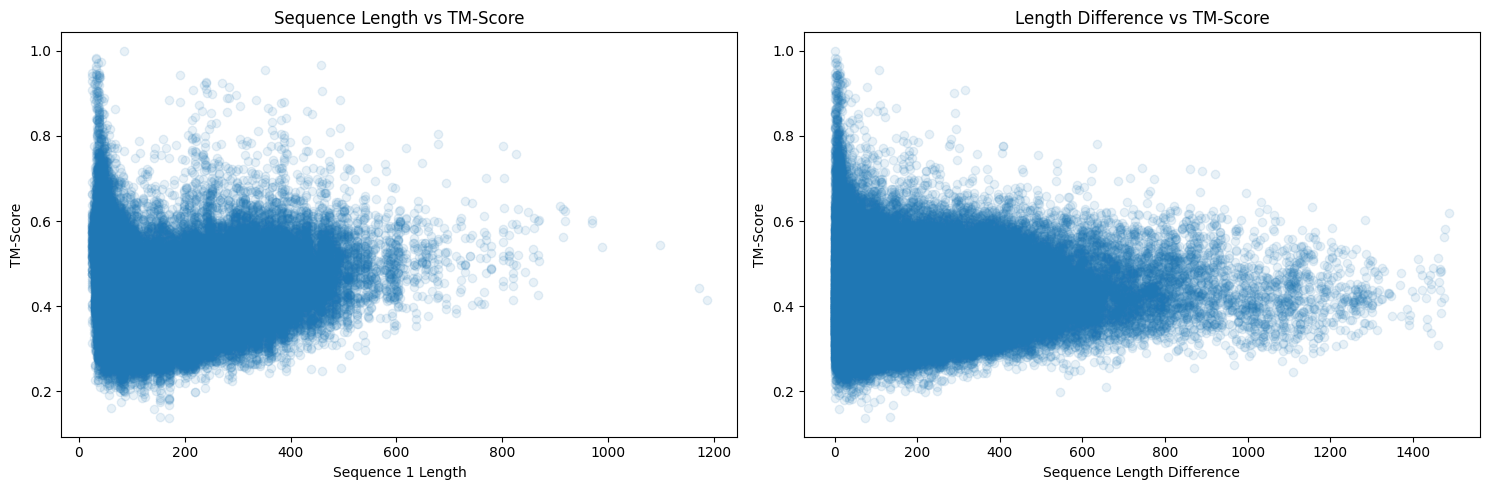

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, skew, kurtosis

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')
tm_scores = results_df['TM_Score_Prediction']

# 1. Basic Statistical Measures
print("Basic Statistical Analysis:")
print("-" * 50)
print(f"Mean TM-Score: {tm_scores.mean():.4f}")
print(f"Median TM-Score: {tm_scores.median():.4f}")
print(f"Standard Deviation: {tm_scores.std():.4f}")
print(f"Variance: {tm_scores.var():.4f}")
print(f"Minimum: {tm_scores.min():.4f}")
print(f"Maximum: {tm_scores.max():.4f}")

# Calculate quartiles
q1, q3 = np.percentile(tm_scores, [25, 75])
iqr = q3 - q1
print(f"\nQuartile Analysis:")
print(f"First Quartile (Q1): {q1:.4f}")
print(f"Third Quartile (Q3): {q3:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

# 2. Distribution Analysis
print("\nDistribution Analysis:")
print("-" * 50)
print(f"Skewness: {skew(tm_scores):.4f}")
print(f"Kurtosis: {kurtosis(tm_scores):.4f}")

# Normality test
stat, p_value = normaltest(tm_scores)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"Statistic: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print("Conclusion: Data is", "normally distributed" if p_value > 0.05 else "not normally distributed")

# 3. Visualizations
plt.figure(figsize=(15, 10))

# Histogram with KDE
plt.subplot(2, 2, 1)
sns.histplot(tm_scores, kde=True)
plt.title('Distribution of TM-Scores')
plt.xlabel('TM-Score')
plt.ylabel('Count')

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=tm_scores)
plt.title('Box Plot of TM-Scores')
plt.ylabel('TM-Score')

# Q-Q plot
plt.subplot(2, 2, 3)
stats.probplot(tm_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=tm_scores)
plt.title('Violin Plot of TM-Scores')
plt.ylabel('TM-Score')

plt.tight_layout()
plt.show()

# 4. Sequence Length Analysis
results_df['Seq1_Length'] = results_df['Sequence 1'].str.len()
results_df['Seq2_Length'] = results_df['Sequence 2'].str.len()
results_df['Length_Difference'] = abs(results_df['Seq1_Length'] - results_df['Seq2_Length'])

print("\nSequence Length Analysis:")
print("-" * 50)
print("\nCorrelation between sequence lengths and TM-Score:")
correlation = np.corrcoef([
    results_df['Seq1_Length'],
    results_df['Seq2_Length'],
    results_df['TM_Score_Prediction']
])
print(f"Correlation (Seq1 Length vs TM-Score): {correlation[0,2]:.4f}")
print(f"Correlation (Seq2 Length vs TM-Score): {correlation[1,2]:.4f}")

# 5. Threshold Analysis
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
print("\nThreshold Analysis:")
print("-" * 50)
for threshold in thresholds:
    above_threshold = (tm_scores >= threshold).sum()
    percentage = (above_threshold / len(tm_scores)) * 100
    print(f"Pairs with TM-Score >= {threshold}: {percentage:.2f}%")

# 6. Additional Visualizations
plt.figure(figsize=(15, 5))

# Sequence length vs TM-Score
plt.subplot(1, 2, 1)
plt.scatter(results_df['Seq1_Length'], results_df['TM_Score_Prediction'], alpha=0.1)
plt.xlabel('Sequence 1 Length')
plt.ylabel('TM-Score')
plt.title('Sequence Length vs TM-Score')

# Length difference vs TM-Score
plt.subplot(1, 2, 2)
plt.scatter(results_df['Length_Difference'], results_df['TM_Score_Prediction'], alpha=0.1)
plt.xlabel('Sequence Length Difference')
plt.ylabel('TM-Score')
plt.title('Length Difference vs TM-Score')

plt.tight_layout()
plt.show()

# Save statistics to file
with open('tm_score_statistics.txt', 'w') as f:
    f.write("TM-Score Statistical Analysis\n")
    f.write("-" * 50 + "\n")
    f.write(f"Total number of pairs analyzed: {len(tm_scores)}\n")
    f.write(f"Mean TM-Score: {tm_scores.mean():.4f}\n")
    f.write(f"Median TM-Score: {tm_scores.median():.4f}\n")
    f.write(f"Standard Deviation: {tm_scores.std():.4f}\n")
    f.write(f"Skewness: {skew(tm_scores):.4f}\n")
    f.write(f"Kurtosis: {kurtosis(tm_scores):.4f}\n")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Calculate cosine similarity for each pair
def calculate_cosine_sim(seq1, seq2):
    unique_chars = set(''.join(results_df['Sequence 1'].tolist() + results_df['Sequence 2'].tolist()))
    char_to_idx = {c: i for i, c in enumerate(unique_chars)}

    vec1 = np.zeros(len(char_to_idx))
    vec2 = np.zeros(len(char_to_idx))

    for char in seq1:
        vec1[char_to_idx[char]] += 1
    for char in seq2:
        vec2[char_to_idx[char]] += 1

    return 1 - cosine(vec1, vec2)

# Calculate cosine similarities
print("Calculating cosine similarities...")
cosine_similarities = [calculate_cosine_sim(seq1, seq2)
                      for seq1, seq2 in zip(results_df['Sequence 1'], results_df['Sequence 2'])]

# Add cosine similarities to the dataframe
results_df['Cosine_Similarity'] = cosine_similarities

# Save the updated dataframe with cosine similarities
output_path = '/content/drive/MyDrive/tm_score_and_cosine_similarities.csv'
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualization
plt.figure(figsize=(12, 8))

# Scatter plot with regression line
sns.regplot(x=cosine_similarities,
            y=results_df['TM_Score_Prediction'],
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title('TM-Score vs Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('TM-Score')

# Calculate and display correlation
correlation = np.corrcoef(cosine_similarities, results_df['TM_Score_Prediction'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes)

plt.savefig('/content/drive/MyDrive/tm_vs_cosine_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nStatistical Summary:")
print("\nCosine Similarity Statistics:")
print(pd.Series(cosine_similarities).describe())
print("\nTM-Score Statistics:")
print(results_df['TM_Score_Prediction'].describe())

# Save statistics to text file
with open('/content/drive/MyDrive/similarity_statistics.txt', 'w') as f:
    f.write("Statistical Analysis Results\n")
    f.write("-" * 50 + "\n")
    f.write(f"Correlation coefficient: {correlation:.4f}\n\n")
    f.write("Cosine Similarity Statistics:\n")
    f.write(pd.Series(cosine_similarities).describe().to_string())
    f.write("\n\nTM-Score Statistics:\n")
    f.write(results_df['TM_Score_Prediction'].describe().to_string())